Image shape at 1 m resolution: (484, 301) pixels
Monthly time windows:

('2021-10-26', '2021-10-26')
('2021-10-26', '2021-10-26')
('2021-10-26', '2021-10-26')


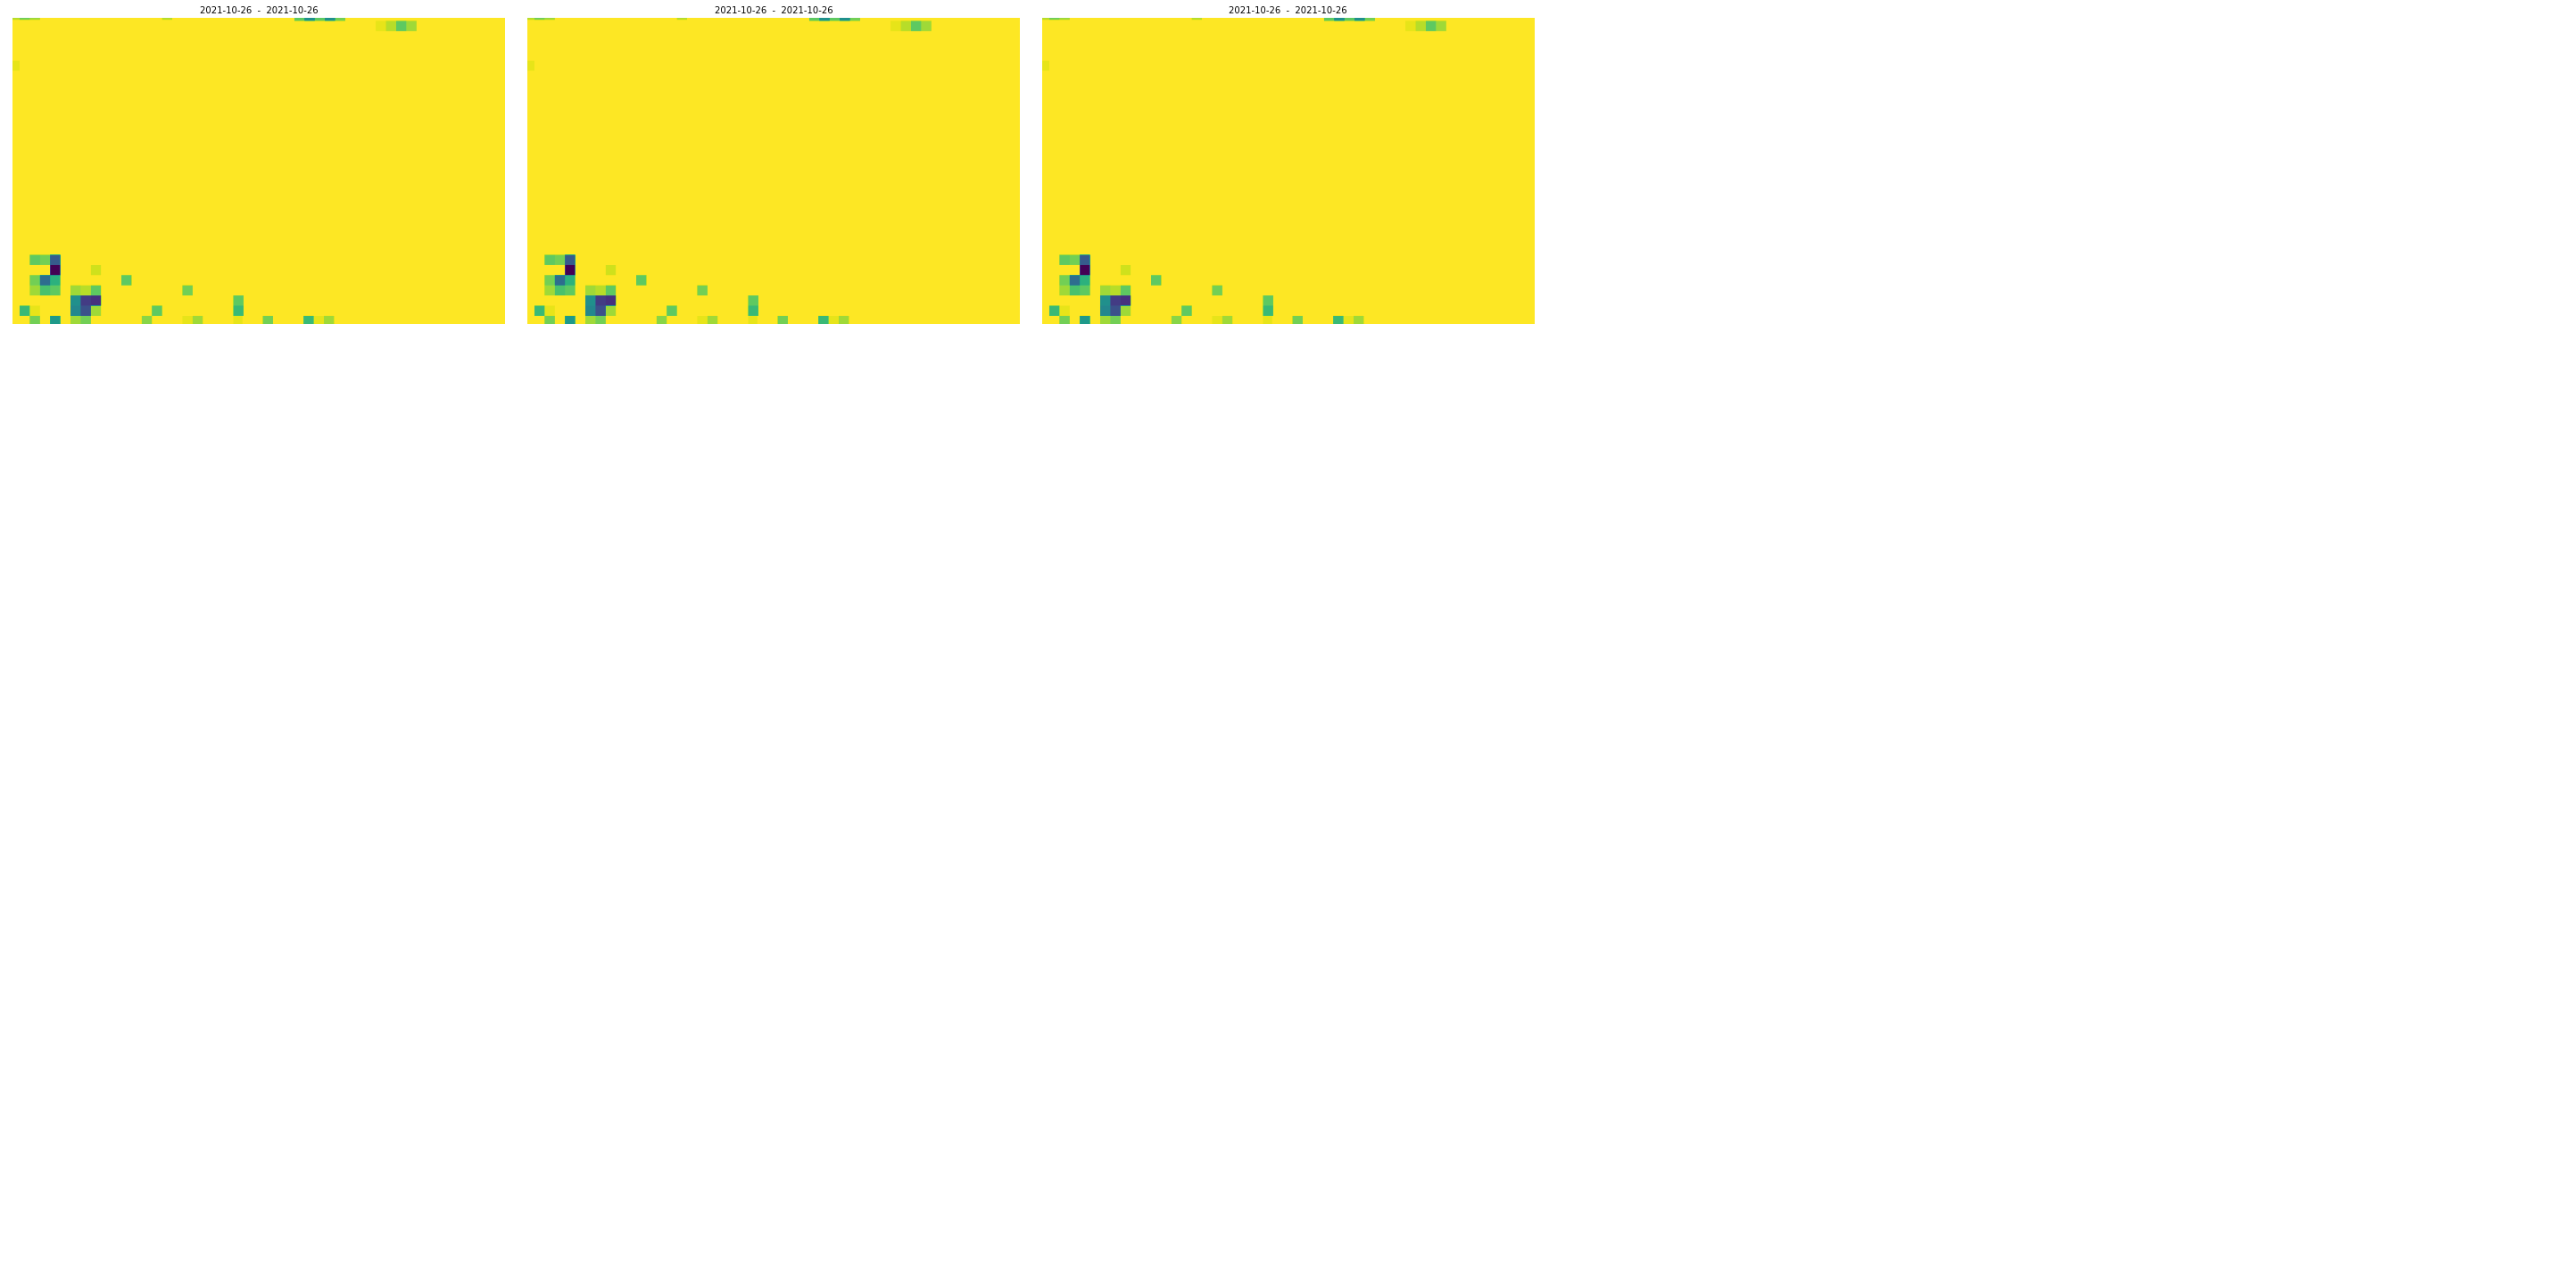

In [45]:
from sentinelhub import SHConfig

config = SHConfig()

#config.sh_client_id = 'c2ddde9c-9bd8-4c8f-a716-2d7426875b24'
#config.sh_client_secret = 'ksTZi62t[J(R[t%/<t})[Hw3I:;0+dqKNI{23nrw'
config.sh_client_id = 'e9d24fd0-226a-480c-818f-5bb6b455b7f8'
config.sh_client_secret = 'Wt%GL/{N*NHNgHuGfN6m|m6O*!%OSa*.YSpX.z:K'
config.save()

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os.path
from PIL import Image

path = os.path.abspath('')
data_path     = Path('/data')

from sentinelhub import MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, \
    DataCollection, bbox_to_dimensions, DownloadRequest

#denmark_cords_wgs84 = [7.847898,54.510765,12.797239,57.946244]
denmark_cords_wgs84 = [9.094491, 55.473442, 9.102162, 55.476142]
resolution = 1
denmark_bbox = BBox(bbox=denmark_cords_wgs84, crs=CRS.WGS84)
denmark_size = bbox_to_dimensions(denmark_bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {denmark_size} pixels')

start = datetime.datetime(2021,10,26)
end = datetime.datetime(2021,10,27)
n_chunks = 4
tdelta = (end - start) / n_chunks
edges = [(start + i*tdelta).date().isoformat() for i in range(n_chunks)]
slots = [(edges[i], edges[i+1]) for i in range(len(edges)-1)]

print('Monthly time windows:\n')
for slot in slots:
    print(slot)

def get_true_color_request(time_interval):
    evalscript_true_color = """
    //VERSION=3
    function setup() {
      return{
        input: [{
          bands: ["B04", "B08"]
        }],
        output: {
          id: "default",
          bands: 1
        }
      }
    }
    function evaluatePixel(sample) {
      let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04)
      return [ ndvi ]
    }
    """
    request = SentinelHubRequest(
        data_folder=path+'/output',
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=time_interval,
                mosaicking_order='leastCC'
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.PNG)
        ],
        bbox=denmark_bbox,
        size=denmark_size,
        config=config
    )
    request.get_data(save_data=True)
    return request

# create a list of requests
list_of_requests = [get_true_color_request(slot) for slot in slots]
list_of_requests = [request.download_list[0] for request in list_of_requests]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)

# some stuff for pretty plots
ncols = 5
nrows = 4
aspect_ratio = denmark_size[0] / denmark_size[1]
subplot_kw = {'xticks': [], 'yticks': [], 'frame_on': False}

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols * aspect_ratio, 5 * nrows),
                        subplot_kw=subplot_kw)

for idx, image in enumerate(data):
    ax = axs[idx // ncols][idx % ncols]
    ax.imshow(np.clip(image * 2.5/255, 0, 1))
    ax.set_title(f'{slots[idx][0]}  -  {slots[idx][1]}', fontsize=10)

plt.tight_layout()